In [ ]:
#Ylonka Machado's Notebook for Project 2: Airbnb Bookings

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd

#Reading Data
train_df = pd.read_csv("train_users_2.csv")
test_df = pd.read_csv("test_users.csv")
sessions_df = pd.read_csv("sessions.csv")

#Removing rows with no bookings
train_df = train_df[train_df.country_destination != 'NDF']

#Removing timestamp_first_active column because of bad date formatting and signup_flow because there is no 
#explanation of what value means
train_df_2 = train_df.drop(['timestamp_first_active','signup_flow'], axis=1)

In [295]:
#Cleaning Data

#Removing rows with null age values, meaning those with ages over 100 or below 18
train_df_2 = train_df_2[train_df_2.age < 100] 
train_df_2 = train_df_2[train_df_2.age >= 18]

#Removing rows with "-unknown-" gender values
train_df_2 = train_df_2[train_df_2.gender != '-unknown-']

#Removing rows with "-unknown-" first browsers
train_df_2 = train_df_2[train_df_2.first_browser != '-unknown-']

#After all this cleaning, I am down to 72,097 rows! 

#Now for one hot encoding
ohe_feats = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    train_df_2_dummy = pd.get_dummies(train_df_2[f], prefix=f)
    train_df_2 = train_df_2.drop([f], axis=1)
    train_df_2 = pd.concat((train_df_2, train_df_2_dummy), axis=1)
    

In [299]:
#Analysis of Model Performance: Linear Regression
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder

target = train_df_2['country_destination'].values
le = LabelEncoder()
target = le.fit_transform(target)

X = train_df_2.drop(['id','date_account_created','date_first_booking','country_destination'], axis=1)
#print(train_df_2.head())
y = target

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

predictions = lm.predict(X)
print(lm.score(X,y))
#0.75% R^2 score :(

0.00758449162512


In [308]:
#Analyzing Features: Linear Regression
features = list(X)

#Seeing predictors and their respective coefficients
for x in range(len(features)):
    print(features[x],lm.coef_[x])

age -0.00374642482163
gender_FEMALE 1.22040970255e+12
gender_MALE 1.22040970255e+12
gender_OTHER 1.22040970255e+12
signup_method_basic 139767014736.0
signup_method_facebook 139767014736.0
signup_method_google 139767014736.0
language_ca 1134909133.65
language_cs 1134909131.97
language_da 1134909132.93
language_de 1134909132.22
language_el 1134909130.77
language_en 1134909132.71
language_es 1134909132.73
language_fi 1134909132.94
language_fr 1134909132.06
language_hu 1134909133.98
language_is 1134909134.06
language_it 1134909132.36
language_ja 1134909133.01
language_ko 1134909133.07
language_nl 1134909132.57
language_no 1134909132.88
language_pl 1134909131.83
language_pt 1134909133.66
language_ru 1134909132.56
language_sv 1134909133.17
language_th 1134909133.59
language_tr 1134909133.22
language_zh 1134909133.34
affiliate_channel_api -46586011431.1
affiliate_channel_content -46586011431.3
affiliate_channel_direct -46586011431.1
affiliate_channel_other -46586011430.8
affiliate_channel_rem

In [310]:
#Analysis of Model Performance: RandomForest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150,verbose=1,n_jobs=-1,oob_score=True,max_features=None,class_weight='balanced')
rf.fit(X,y)

accuracy = rf.score(X,y)
print(accuracy)
#44% accuracy

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   40.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


0.44486928168


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.8s finished


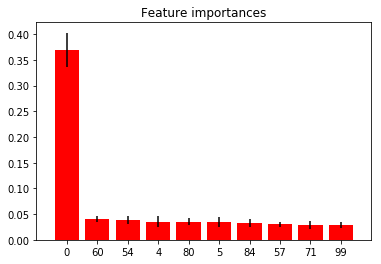

age
first_affiliate_tracked_untracked
first_affiliate_tracked_linked
signup_method_basic
first_browser_Chrome
signup_method_facebook
first_browser_Firefox
first_affiliate_tracked_omg
first_browser_Safari
first_device_type_Windows Desktop


In [228]:
#Analyzing Features: RandomForest

#Listing all features and their importance
importances = rf.feature_importances_

for x in range(0,len(importances)):
    print(features[x],":",importances[x])

import matplotlib.pyplot as plt

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(top_k), importances[new_indices],
       color="r", yerr=std[new_indices], align="center")
plt.xticks(range(top_k), new_indices)
plt.xlim([-1, top_k])
plt.show()

features = list(X)
top_10_features = [features[0],features[60],features[54],features[4],features[80],features[5],features[84],features[57],features[99],features[71]]
for x in top_10_features:
    print(x)

In [319]:
#Analysis of Model Performance: kNN
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(accuracy_score(y_test,pred))

#57% accuracy rate with 3 neighbors
#66% accuracy rate with 5 neigbors

0.659295418456


In [ ]:
#Tuning Parameters: kNN
from sklearn.model_selection import cross_val_score
import scikitplot as skplt

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)
'''
#List of Odds for kNN
myList = []
for x in range(0,51):
    if x % 2 != 0:
        myList.append(x)
'''
        
#List of Cross Validation Scores
cv_scores = []

#10-fold Cross Validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

#Changing to misclassification error
MSE = [1 - x for x in cv_scores]
#print(MSE)

#Determining optimal number of neighbors
#optimal_k = myList[MSE.index(min(MSE))]
#print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [ ]:
#Tuning Parameters: kNN
from sklearn.model_selection import cross_val_score
import scikitplot as skplt

# creating odd list of K for KNN
myList = list(range(1,50))

print(myList)

In [ ]:
#Running model again with optimal number of neighbors
knn_2 = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred_2 = knn_2.predict(X_test)
print(accuracy_score(y_test,pred_2))